# Committor simulations
This notebook showcases how to setup and perform a `CommittorSimulation` of capped alanine dipeptide from python. We will use the $C7_{eq}$ and $\alpha_R$ states as final states (stopping conditions) for the trial propagations. To perform a `CommittorSimulation` with your favorite molecular system, you just need to adapt the state functions and the initial configurations to your needs.

This notebook also shows how to easily (given you have access to promising initial configurations) generate transitions between states using two way shooting. These transitions can, e.g., be used as input to a Transition Path Sampling simulation.

**This notebook should be run on a multi-core workstation**, otherwise you will have a very long coffee break and a very hot laptop.

**Required knowledge/recommended reading:** This notebook assumes some familiarity with the `asyncmd` python package, i.e. we will use a MD engine class (the `GmxEngine`) and the `PyTrajectoryFunctionWrapper` from the `asyncmd` package. Please have a look at the [asyncmd documentation/examples](https://asyncmd.readthedocs.io/en/latest/) if anything regarding their usage is unclear.

### Imports and working directory

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import asyncmd
import asyncmd.gromacs as async_gmx

from aimmd.distributed import (CommittorConfiguration,
                               CommittorEngineSpec,
                               CommittorSimulation,
                               )

Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_all_slurm_settings()` or `asyncmd.config.set_slurm_setting()` with the appropriate arguments.
/home/think/Documents/sources/OPS/aimmd/aimmd/base/storage.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [ ]:
# working directory
workdir = "Committors_capped_alanine"

## Setup the `CommittorSimulation`

The `CommittorSimulation` is a python class to perform an arbitrary number of committor trials from multiple starting configurations at the same time.
To run it we need to define the states (functions returning True or False for every configuration, i.e. if it belongs to a given state or not), a list of starting configurations (as `CommittorConfigurations`), and the specification of the MD engine used to propagate the trials (as `CommittorEngineSpec`).

The `CommittorSimulation` will always perform an equal number of trials per configuration (controlled via the `trials_per_configuration` argument to the `run` method) and you can easily control the maximum number of simultaneously performed trials via the `n_max_concurrent` argument.
The `CommittorSimulation` can optionally perform two way trials, i.e., perform additional trials with inverted momenta for every (or a subset) of the starting configurations.
In this case it will also write out transition trajectories if the forward and backward trials reach different states.
Note that, except if the dynamics is truly diffusive, the outcomes of the forward and backward trials will always be correlated.
The shooting statistics of the forward and backward trials are therefore kept separate and returned via the two attributes `states_reached` and `states_reached_backward`.

### States

State functions are functions that take an `asyncmd.Trajectory` and return an array of True or False values (of shape `(len(trajectory),)`), i.e., indicate for every configuration/frame of the trajectory if it lies in a given state.
To make the application of a state functions on multiple trajectories at the same time easily possible and to profit from the automatic value caching, state functions are expected to be `asyncmd.trajectory.functionwrapper.TrajectoryFunctionWrapper` subclasses, e.g. `asyncmd.trajectory.PyTrajectoryFunctionWrapper` or `asyncmd.trajectory.SlurmTrajectoryFunctionWrapper`.

In our example here we will import the predefined state functions for the $C7_{eq}$ and $\alpha_R$ states included with the aimmd examples.
They are simple functions implemented in MDAnalysis and you are highly encouraged to have a look at the python file in the directory of the notebook to have a look at them.

In [4]:
# import state functions
from state_funcs_mda import alpha_R, C7_eq

# and wrap them
wrapped_alphaR = asyncmd.trajectory.PyTrajectoryFunctionWrapper(alpha_R)
wrapped_C7_eq = asyncmd.trajectory.PyTrajectoryFunctionWrapper(C7_eq)

### `CommittorConfiguration`

Here, we will make use of the transition trajectory connecting the $C7_{eq}$ and $\alpha_R$ states to have an easy source of configurations belonging to no state.
The trajectory is included with the example notebooks in the repository and also serves as input to various Transition Path Sampling simulations.
We will load it and pick a number of evenly spaced (in time) configurations from it.

The `CommittorConfiguration` is a simple dataclass holding information about the initial configuration for committor simulations, namely:
- the trajectory this configuration lies on (an `asyncmd.Trajectory` object),
- the index of the configuration in said trajectory,
- and, optionally, a name for the configuration which will be used in the directory structure created by the `CommittorSimulation`.

In [5]:
# Load the transition to take initial configurations from
tp_traj = asyncmd.Trajectory(trajectory_files="gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr",
                             structure_file="gmx_infiles/conf.gro")
print(f"The transition has a length of {len(tp_traj)} frames.")

The transition has a length of 102 frames.


In [6]:
# have a look at the results of our state functions
# Note that the transition is from a slightly less strict alpha_R function,
# therefore the first four frames here are inside alpha_R
print("alpha_R result: ", await wrapped_alphaR(tp_traj))
print("C7_eq result: ", await wrapped_C7_eq(tp_traj))

alpha_R result:  [ True  True  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
C7_eq result:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False

In [7]:
# prepare the list of starting configurations
# we just pick 10 configurations equally spaced,
# but exclude the configurations that are inside any state
n_confs_to_pick = 10
starting_confs = [CommittorConfiguration(trajectory=tp_traj,
                                         index=i,
                                         name=f"frame{i}_from_low_barrier_transition",
                                         )
                  for i in range(4, len(tp_traj) - 1, n_confs_to_pick)
                  ]
print(f"Selected {len(starting_confs)} frames as starting configurations.")

Selected 10 frames as starting configurations.


### `CommittorEngineSpec`

The `CommittorEngineSpec` defines all things related to the MD engine performing the trial propagation. Most of the initialization arguments of the `CommittorEngineSpec` are used to define the MD engine via `asyncmd` (see its (documentation on gromacs engines)[https://asyncmd.readthedocs.io/en/latest/guide/gromacs.html]), the only other mandatory argument is `walltime_per_part`.

The trials of the `CommittorSimulation` are propagated in parts, each with a walltime of `walltime_per_part`.
Only after each part, the trajectory is checked if a state has been reached or if the propagation must be continued.
It is therefore important to choose `walltime_per_part` such that it not too long and (unnecessary) MD integration inside of one of the states (after a stopping condition was reached) is performed.
On the other hand a **very** short `walltime_per_part` will result in unnecessary overhead of starting and shutting down the MD program.
Note that, a large plus of propagation in short parts is that it can make efficient use of [backfilling on an HPC cluster](https://slurm.schedmd.com/sched_config.html#backfill), i.e. it will make your simulation finish faster while helping to optimally utilize the cluster you run on.

You can also define a maximum number of integration steps to perform to avoid that trials get stuck in unknown metastable states via the `max_steps` argument.

If you are not using a gromacs engine, you might need to change the `full_precision_traj_type` argument from its default value of `"trr"` to something your engine can use as a full precision format (including velocities and positions).

In [8]:
# engine_kwargs for asyncmd.gromacs.GmxEngine
gro = "gmx_infiles/conf.gro"
top = "gmx_infiles/topol_amber99sbildn.top"
ndx = "gmx_infiles/index.ndx"
mdp = async_gmx.MDP("gmx_infiles/md.mdp")
print(f"The reference temperature ('ref-t') in the mdp file is: {mdp['ref-t']}.")
# put them in a dictionary
engine_kwargs = {"mdconfig": mdp, "gro_file":gro,
                 "top_file":top, "ndx_file":ndx,
                 "mdrun_extra_args": "-nt 2",
                 "output_traj_type": "XTC",
                 }

# and initialize the CommittorEngineSpec dataclass
committor_engine_spec = CommittorEngineSpec(
                                engine_cls=async_gmx.GmxEngine,
                                engine_kwargs=engine_kwargs,
                                walltime_per_part=0.2/360,  # 0.2 s per part
                                )

The reference temperature ('ref-t') in the mdp file is: [300.0, 300.0].


### Initialize the `CommittorSimulation`

Here we will initialize the `CommittorSimulation` using our previously defined states, configurations, and engine specification.

Note that you can set all attributes of the `CommittorSimulation` (e.g. how many retries to perform in various cases `max_retries_on_max_steps`/`max_retries_on_crash`, the directory names `directory_forward`/`directory_backward`/etc., or the names of the output trajectory files `fileout_trajectory_to_state`/`fileout_trajectory_to_state_backwards`/`fileout_transition_trajectory`/etc.) at initialization time by passing them as keyword arguments with the respective values you want to use.

Also note that the `CommittorSimulation` allows the simulation of different physical ensembles for different starting configurations.
To this end the `CommittorSimulation` allows to vary some of the simulation parameters on a per configuration basis.
These can be either a list of values (length must then be equal to the number of `configurations`) or a single value.
This means you can simulate systems differing in the number of molecules, at different pressures, or at different temperatures (by using different :class:`CommittorEngineSpec`) and even perform two way trials only for a selected subset of configurations (e.g. the ones you expect to be a transition state).

In [9]:
# here we simply use the same engine specification (and temperature) for all configurations,
# i.e. all molecular dynamics simulations of this committor simulation use the same MD integration options
simulation = CommittorSimulation(workdir=workdir,
                                 configurations=starting_confs,
                                 states=[wrapped_alphaR, wrapped_C7_eq],
                                 temperature=mdp["ref-t"][0],
                                 committor_engine_spec=committor_engine_spec,
                                 # if we would want to, e.g. change max_retries_on_max_steps:
                                 #max_retries_on_max_steps=2,
                                 )

## Run the `CommittorSimulation`

In [10]:
# now run the simulation for 10 shots per configuration
# run at most 20 trials simultaneously
await simulation.run(10, n_max_concurrent=20)

100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


## Analyze and plot the results

### Plot committor estimates for every starting configuration

The `states_reached` (and `states_reached_backward`) attributes of the `CommittorSimulation` aggregate the shooting statistics for every starting structure as numpy arrays.

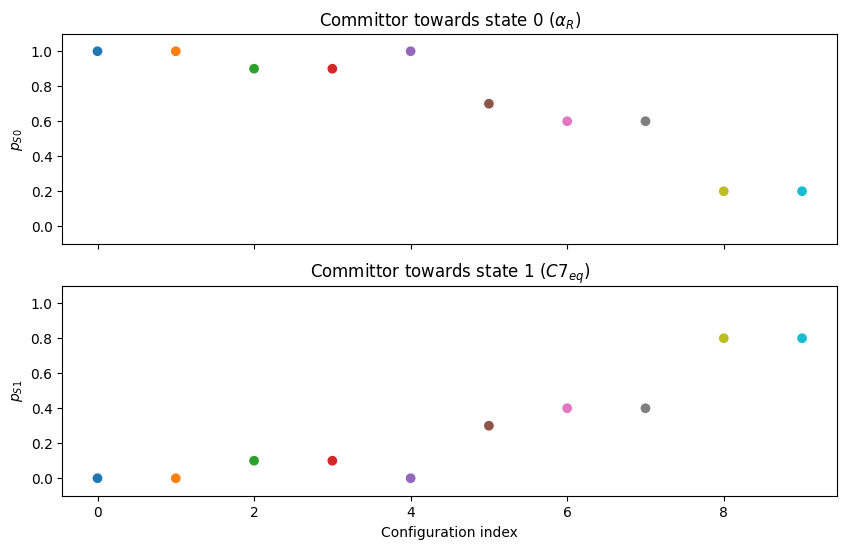

In [11]:
# states_reached already aggregates the result for the same starting configuration
# it therefore has shape = (n_conf, n_states)
n_conf, n_states = simulation.states_reached.shape

# get a colorbar and a normalize instance to have different colors for starting structure
#cmap = matplotlib.colormaps.get_cmap("viridis")
cmap = matplotlib.colormaps.get_cmap("tab10")
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_conf-1)

fig, axs = plt.subplots(figsize=(10,6), nrows=n_states, sharex=True)
for snum, (ax, name) in enumerate(zip(axs, [r"$\alpha_R$", r"$C7_{eq}$"])):
    ax.set_title(f"Committor towards state {snum} ({name})")
    ax.scatter(x=np.arange(n_conf),
               y=simulation.states_reached[:, snum] / np.sum(simulation.states_reached, axis=1),
               c=cmap(norm(np.arange(n_conf))),
               )
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel(f"$p_{{S{snum}}}$")
    if snum == 1:
        ax.set_xlabel("Configuration index")

### Plot results for every shot separately

The attributes `states_reached_per_trial` (and `states_reached_per_trial_backward`) perform no aggregation, i.e., they contain the results for every trial separately.

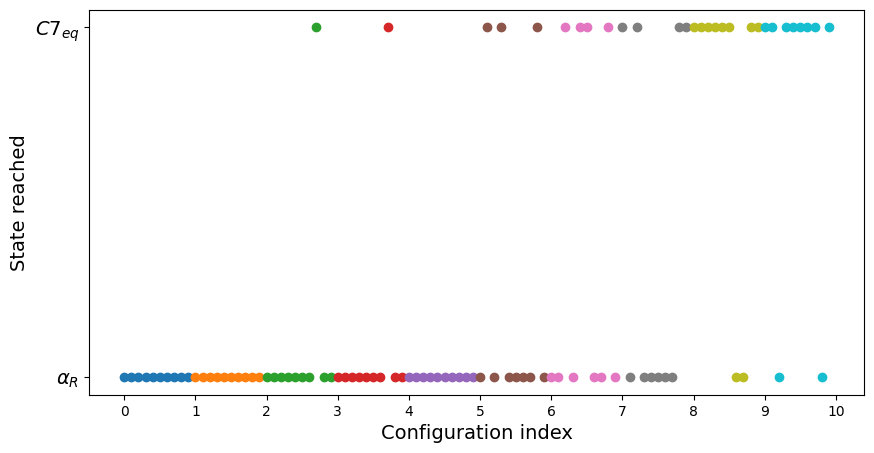

In [12]:
fig, axs = plt.subplots(figsize=(10, 5))

# look at the shooting results per stucture and trial,
# i.e. it has shape = (n_conf, n_trial, n_states)
# it can be accessed as `CommittorSimulation.states_reached_per_trial`
n_conf, n_trial, n_states = simulation.states_reached_per_trial.shape
xses_per_conf = np.arange(0, n_trial)

for cnum, states_reached_per_conf in enumerate(simulation.states_reached_per_trial):
    plot_vals = np.full((n_trial,), np.nan)  # fill with nan values to plot nothing
    # get the idxs of the shot and idx of the state each shot reached
    idxs, state = np.where(states_reached_per_conf)
    plot_vals[idxs] = state  # and plot only where we reached the given state
    axs.scatter(x=xses_per_conf + (n_trial * cnum),
                y=plot_vals,
                color=cmap(norm(cnum)),
                )

axs.set_yticks([i for i in range(n_states)])
axs.set_yticklabels([r"$\alpha_R$", r"$C7_{eq}$"], size=14)
axs.set_xticks([n_trial * i for i in range(n_conf + 1)],
               [str(i) for i in range(n_conf + 1)])
axs.set_xlabel("Configuration index", size=14)
axs.set_ylabel("State reached", size=14);

## Add "backward" trials to generate initial transitions

We will now add the conjugate "backward" trials for the most promising configurations, i.e. those with shots that reached both states.

To this end we will simply set the `two_way` attribute to a list with bool values.
In this list we set `True` for the configurations with $0.25 < p_{C7_{eq}} < 0.75$, i.e. those we want to perform two way trials for.
After this we only need to call the `add_missing_backward_trials` method and the `CommittorSimulation` will add the backward trials for the configurations we requested.

In addition to adding the missing backwards trials, this will also write out any potentially generated transitions as one concatenated trajectory from the lower index state to the higher index state (the trajectory will start with the first frame in a state and end last frame in another state).

The two way trial propagation can be used to generate initial transitions, e.g. for a subsequent transition path sampling simulation.
Note however, that this is usually only worth spending computational effort for configurations that have an roughly equal probability to reach both/multiple states, i.e. for potential transition states.
It is therefore advisable to perform a similar workflow as we do here, where two way trials are only performed after an initial committor simulation to identify worthwhile candidates.

Another potential use-case for two way trials is to asses how diffusive the dynamics of the molecular system is, i.e., how correlated the forward and backward realizations are.

In [13]:
# estimate probability to reach C7_eq
p_c7_eq = simulation.states_reached[:, 1] / np.sum(simulation.states_reached, axis=1)
print("Will perform two way trials for configurations with the following indices: ",
      np.where((0.25 < p_c7_eq) & (p_c7_eq < 0.75)),
      )

# set two_way=True for the respective configurations
two_way = [False for _ in range(len(simulation.configurations))]
for idx in np.where((0.25 < p_c7_eq) & (p_c7_eq < 0.75))[0]:
    two_way[idx] = True

simulation.two_way = two_way

Will perform two way trials for configurations with the following indices:  (array([5, 6, 7]),)


In [14]:
# now add the missing backward trials
await simulation.add_missing_backward_trials()

100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


In [15]:
# now the states_reached_backward property will also contain non-zero values
simulation.states_reached_backward

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [5., 5.],
       [8., 2.],
       [2., 8.],
       [0., 0.],
       [0., 0.]])

## Accessing the generated trajectories

The concatenated output trajectories until a state is reached and the (potentially) generated transition trajectories can all be found inside the respective trial folders, however they can also be accessed from python via the properties `trajectories_to_state`, `trajectories_to_state_backward` and `transition_trajectories`.
Each of these will return a list of list, where the outer list corresponds to configurations and the inner list to the trials for that respective configuration.

In [16]:
print("Trajectories to state: ", simulation.trajectories_to_state)
print("Trajectories to state backward: ", simulation.trajectories_to_state_backward)
print("Transition trajectories: ", simulation.transition_trajectories)

Trajectories to state:  [[Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_capped_alanine/frame4_from_low_barrier_transition/trial_0/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro), Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_capped_alanine/frame4_from_low_barrier_transition/trial_1/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro), Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_capped_alanine/frame4_from_low_barrier_transition/trial_2/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro), Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_capped_alanine/frame4_from_low_barrier_transition/trial_3/trajectory_to_state.xtc, structure_file=gmx_infiles/conf.gro), Trajectory(trajectory_files=../../../../../../scratch/aimmd_distributed/Committors_capped_alanine/frame4_from_low_barrier_transition/trial_4/trajectory_to_sta

## Changing the states or refining the state definitions

It is possible to modify the `states` of a `CommittorSimulation` and reuse any existing MD integration in a working directory.
This can mean both, loosening or tightening the definition of (some) states, or even adding/removing states altogether.
Using the `reinitialize_from_workdir` method, the `CommittorSimulation` will reassess all existing trials using the current `states` and perform any MD trial propagation necessary to fulfill the new state definitions.
In real-life situations, it can be very useful to be able to reassess a committor simulation with an improved state definition, or after adding an additional, previously unknown state.

However, our example here is a bit senseless as we will simply reinitialize/rerun the `CommittorSimulation` from before, but now with only one state, $\alpha_R$.
This means we will propagate all trials that ended up in $C7_{eq}$ until they reach $\alpha_R$ (which might take some time as they are already in a metastable state) and do nothing for the trials that already reached $\alpha_R$ before.

In [17]:
simulation.states = [wrapped_C7_eq]
# and give the output trajectories new/different names
simulation.fileout_trajectory_to_state = "continuation_traj_to_state"
simulation.fileout_trajectory_to_state_backward = "continuation_traj_to_state_backwards"
# not needed as there can be no transitions with only one state...but for completeness
simulation.fileout_transition_trajectory = "continuation_transition"
# NOTE: we could have also just passed `overwrite=True` to `reinitialize_from_workdir`
#       to overwrite potentially existing concatenated output trajectories

In [18]:
# since the concatenated output trajectories have different names we can pass overwrite=False
#  (the default is True!)
await simulation.reinitialize_from_workdir(overwrite=False, n_max_concurrent=20)

100%|██████████| 100/100 [09:52<00:00,  5.93s/it]


In [19]:
# states_reached will be very boring now, as we have only one state
# and that will be reached on every trial...
simulation.states_reached

array([[10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.]])